# Projet de permanence : Découverte des outils de classification et de clustering

## Prérequis

Un peu de curiosité et de patience feront l'affaire ! ;)

Plus sérieusement, il vous faut soit [Google colab'](https://colab.research.google.com/), soit un environnement Python avec `tensorflow`, `numpy`, `keras`et `scikit-learn`.

## Introduction

L'objectif de ce sujet est de vous faire découvrir les librairies **Keras** et **scikit-learn** en vous permettant d'avoir vos premiers résultats de **Machine Learning** avec le dataset **CIFAR10**.

Nous allons aborder les notions suivantes : les couches denses, les CNNs, les auto-encodeurs, le clustering, ...

Le plan est le suivant :

1. **La classification supervisée :** Prédiction du label d'une image grâce à un réseau de neurones
2. **Les autoencodeurs :** Concept et 3 applications qui vont changer votre vie !
3. **La classification non-supervisée :** Le secret derrière Argos.

Ci-dessous une petite FAQ pour vous présenter certains points. Si vous avez des questions ou des remarques, n'hésitez pas à les poser aux 2As présents en perm' ou sur le groupe Automatants. Good luck, have fun !

## FAQ

### Comment ça marche un fichier Jupyter ?

Les fichiers Jupyter vous permettent d'exécuter du Python depuis votre navigateur, tout en pouvant alterner morceaux de code et morceaux de textes. Afin d'éxécuter du code, il faut appuyer sur `Crtl` + `R` (Reste sur le bloc courant) ou `Shift` + `R` (Exécute le bloc courant et passe au bloc suivant).

Tous les `print` ou `plot` que vous ferez s'afficheront directement en dessus du bloc de code.

### Qu'est-ce qu'un dataset ?

Un **dataset** est un jeu de données, qui généralement associe à des données d'entrée une ou plusieurs données de sortie.

Par exemple, le dataset MNIST associe à des images en nuance de gris le chiffre qu'elle représente.

Ici, nous allons manipuler le dataset CIFAR10 qui à des images en couleur associe le nom de de ce qu'elle représente (Plus de détails dans la suite).

La construction d'un dataset bien labelisé et conséquent est une des difficultés majeures en Machine Learning. Heureusement pour nous, de nombreux datasets existent et sont mis à disposition de tous !

### Mais c'est quoi Keras?

**Keras** est une libraire qui permet de rapidement créer des réseaux de neurones et de les entrainer. De nombreuses couches sont déjà codées, telles que les couches denses (du multi-perceptron), des CNNs, des couches récurrentes, etc., ce qui permet de n'avoir qu'à les assembler. Keras inclut également plusieurs datasets, ce qui est très pratique pour tester des algorithmes.

### Et scikit-learn ?

De son côté **scikit-learn** propose beaucoup d'outils pour faire de l'analyse prédictive de données (Classification, régression, clustering, réduction de dimension, etc. *Beaucoup de termes barbares que vous allez découvrir dans la suite*).

# Import des librairies et des données

## Les librairies

Commençons par importer les librairies dont nous aurons besoin.

In [1]:
from time import time
import tensorflow as tf
import numpy as np

from tensorflow import keras

from tensorflow.keras import datasets, layers, models, losses
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import matplotlib

## Le dataset

Importons maintenant le dataset. Nous allons utiliser CIFAR10, dont voilà une description :

> L'ensemble de données CIFAR10 contient 60 000 images couleur de 32x32 dans 10 classes, avec 6 000 images dans chaque classe. L'ensemble de données est divisé en 50 000 images d'entraînement et 10 000 images de test. Les classes sont mutuellement exclusives et il n'y a pas de chevauchement entre elles.

Pour rappel, il est important de séparer les données en données d'entrainement et données de test. Cela permet de constater si notre modèle a effectué un sur-apprentissage (overfitting) et est incapable de généraliser ce qu'il a appris.

**Keras** inclut de nombreux datasets dans son modèle `datasets` ([liste des datasets](https://keras.io/api/datasets/)) que l'on peut importer avec la fonction `load_data`.

Les valeurs des pixels varient entre 0 et 255. Nous allons les normaliser pour qu'elles soient entre 0 et 1, ce qui est plus adapté pour les réseaux de neurones.

In [2]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

train_images, test_images = train_images / 255.0, test_images / 255.0

Visualisons un peu toutes ces images ! On utilisera `np.argmax` pour récupérer le numéro de la classe à partir du vecteur de 0 et de 1.

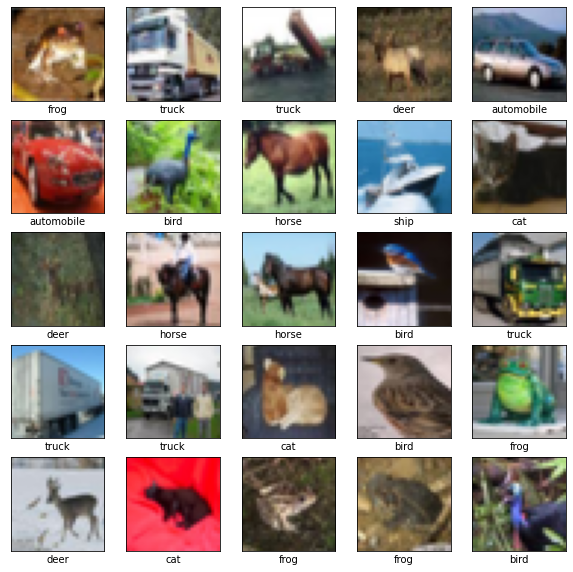

In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

Parfait, nous pouvons maintenant commencer les choses sérieuses !

# Classification supervisée

## Qu'est-ce que la classification supervisée ?

L'idée est de trouver une fonction de prédiction à partir des données annotées. Ici, cela revient à trouver la fonction qui à chaque image associe son label.

Cela est différent de l'apprentissage non-supervisé que l'on fera dans la suite.

## Comment allons-nous faire ?

Les images font 32 pixels par 32 avec 3 valeurs pour chaque couleur (**R**ouge, **V**ert, **B**leu ou **RVB** en français et **RGB** en anglais). Nous avons donc 32 x 32 x 3 = 3072 paramètres ...

Nous allons donc utiliser des réseaux de neurones pour approximer notre fonction de prédiction !

## Avec un réseau dense

### Rappel théorique

Si vous assistez aux premières formations, vous savez ce qu'est un réseau dense et si vous avez assisté au TP Multiperceptron, vous avez même codé votre propre réseau dense !

Pour ceux qui ne s'en souvienne plus, un réseau de neurones dense est composée de plusieurs couches, elles-mêmes composées de plusieurs noeuds. Chaque noeud est relié à tous les noeuds de la couche précédente, dont il pondère la somme des valeurs par des poids, et décale la valeur obtenue par un biais. Finalement, pour éviter que l'ensemble de toutes les couches se résument à une seule couche, on casse la linéarité en associant à chaque couche une fonction d'activation (sigmoïde, tanh, relu, etc.).

C'est une explication très très succinte. Pour mieux comprendre ce que c'est, vous pouvez revoir la formation sur les premières formations, ou il y a ces excellentes vidéos de [Science4All, Les réseaux de neurones | Intelligence artificielle 41](https://www.youtube.com/watch?v=8qL2lSQd9L8) (FR) et de [3Blue1Brown, But what is a Neural Network?](https://www.youtube.com/watch?v=aircAruvnKk) (ANG, mais très visuel).

![](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3d/Neural_network.svg/220px-Neural_network.svg.png)

La première couche est appelée `Input layer`, car c'est là que sont insérées les données d'entrée. La dernière couche est appelée `Output layer` et correspond aux valeurs de sortie. Les couches intermédiaires sont appelées `Hidden layer`.

### En pratique

#### Création du modèle

Pour créer un modèle avec **Keras**, on peut utiliser `keras.models.Sequential()`.

**Instruction :** Créer un modèle que vous assignerez à `model_dense1`.

In [6]:
model_dense1 = keras.models.Sequential()

Il est maintenant temps d'ajouter les premières couches à ce modèle. On pourra utiliser :
- `model_dense1.add(layer)` qui ajoute layer à la suite des couches du modèle.


- `keras.layers.Dense(n_noeuds, activation='...')` qui renvoie une couche dense avec `n_noeuds` noeuds et comme fonction d'activation celle que vous avez précisez (les options possibles sont notamment `sigmoid`, `tanh`, `relu`, `softmax`)

  Plus d'infos dans la doc de Keras : [Dense Layer](https://keras.io/api/layers/core_layers/dense/).


- `keras.layers.Flatten(input_shape=shape)` qui renvoie une couche qui *aplatit* les données d'entrée en une liste à la sortie.

  `input_shape` est un tuple qui permet de préciser le format des données d'entrée (Exemple (32, 32, 3) pour les images de CIFAR10).

Maintenant, réfléchissons un peu. Nos données d'entrée sont de la forme (32, 32, 3). Or, une couche dense ne peut prendre qu'une liste en entrée ... Il va donc falloir utiliser utiliser une première couche `Flatten` pour avoir le bon format.

**Instruction :** Rajoutez une couche `Flatten` au modèle.

*Note :* On pourrait également modifier les données d'entrée, mais vu que dans la suite, on va remanier les images, ça ne serait pas pratique.

In [7]:
model_dense1.add(keras.layers.Flatten(input_shape=(32, 32, 3)))

À la sortie de cette couche, nous avons donc une liste de 32 x 32 x 3 valeurs. On peut donc enfin mettre une première couche cachée !

**Instruction :** Rajoutez une couche `Dense` avec 512 noeuds et la fonction d'activation `relu`.

In [8]:
model_dense1.add(keras.layers.Dense(512, activation='relu'))

Ajoutons maintenant la couche de sortie, on a 10 classes possibles. Notre dernière couche aura donc 10 noeuds, et on aimerait que notre réseau prédise la probabilité de chaque classe, on utilisera donc la fonction d'activation `softmax`.

**Instruction :** Rajoutez une couche `Dense` avec 10 noeuds et la fonction d'activation `softmax`.

In [9]:
model_dense1.add(keras.layers.Dense(10, activation='softmax'))

#### Visualisation du modèle, et compilation

Vous avez créé votre premier modèle, félicitations ! Voyons voir un peu ce qu'il contient.

La fonction `summary()` affiche un résumé des couches de votre modèle, ainsi que le nombres de paramètres entrainables, etc.

In [10]:
model_dense1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1573376   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 1,578,506
Trainable params: 1,578,506
Non-trainable params: 0
_________________________________________________________________


Avant d'entrainer notre modèle, il faut qu'on le compile pour l'entrainement. Cela permet notamment de préciser certains paramètres.

On utilisera la fonction `compile(optimizer="adam", loss=..., metrics=...)` :
- `optimizer`
  
  Méthode utilisée lors de la backpropagation. Ici, on utilisera Adam, qui est beaucoup une méthode d'optimisation très efficace, plus efficace que la descente de gradient normale que vous avez vu en formation.

  Plus d'infos sur les optimisateurs : [Various Optimization Algorithms For Training Neural Network](https://towardsdatascience.com/optimizers-for-training-neural-network-59450d71caf6).
  
  
- `loss`

  Précise comment on calcule l'erreur. On utilisera `tf.keras.losses.CategoricalCrossentropy(from_logits=True)` ici.
  
- `metrics`

  Liste des métriques qu'on aimerait suivre. Celle la précision nous intéresse ici, on prendra donc `['accuracy']`.
  
**Instruction :** Compiler votre modèle avec `model_dense1.compile(...)`.

In [11]:
model_dense1.compile(optimizer='adam',
                     loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                     metrics=['accuracy'])

#### Entrainement

Notre modèle est fin prêt pour être entrainé !

On utilisera :

`history = model_dense1.fit(x, y, epochs=..., validation_data=(x_test, y_test))`

- `x`
  
  Les données d'entrée, ici `train_images`.
  
  
- `y`
  
  Les données de sortie, ici `train_labels`.
  
  
- `epochs`
  
  Nombre d'époques à faire pour entrainer notre modèle. Une époque correspond à un passage sur l'ensemble des données `x` et `y`.
  
  On pourra prendra 5 ici.
  
  
- `validation_data=(x_test, y_test)`

  Couple de données entrée / sortie qui ne sont pas utilisées pour entrainer le modèle. Une validation est faite à chaque fin d'époque, et cela permet de voir si notre réseau réussit à généraliser à des nouvelles données ou non.
  
  Nos données de validation sont `test_images` et `test_labels` ici.
  
La fonction `fit()` renvoie l'historique des métriques au cours de l'entrainement.

**Instruction :** Entrainer votre modèle avec `model_dense1.fit(...)`.

In [12]:
history = model_dense1.fit(train_images, train_labels,
                           epochs=5,
                           validation_data=(test_images, test_labels))

Epoch 1/5
1563/1563 [==============================] - 14s 9ms/step - loss: 1.8766 - accuracy: 0.3270 - val_loss: 1.7568 - val_accuracy: 0.3586
Epoch 2/5
1563/1563 [==============================] - 14s 9ms/step - loss: 1.7011 - accuracy: 0.3890 - val_loss: 1.6820 - val_accuracy: 0.3934
Epoch 3/5
1563/1563 [==============================] - 14s 9ms/step - loss: 1.6412 - accuracy: 0.4140 - val_loss: 1.6585 - val_accuracy: 0.4078
Epoch 4/5
1563/1563 [==============================] - 14s 9ms/step - loss: 1.6015 - accuracy: 0.4281 - val_loss: 1.5685 - val_accuracy: 0.4460
Epoch 5/5
1563/1563 [==============================] - 14s 9ms/step - loss: 1.5776 - accuracy: 0.4379 - val_loss: 1.5637 - val_accuracy: 0.4435


Durant l'entrainement, vous voyez pour chaque époque : l'avancement, le temps restant estimé, la loss et la précision. Une fois que l'époque est finie, vous voyez également val_loss et val_accuracy, qui sont la loss et la précision sur les données de test.

Ce sont ces paramètres qui nous intéressent. Dans le meilleur des mondes, la loss diminue, et la précision augmente !

Affichons les données de l'historique, et voyons comment notre modèle s'en sort !

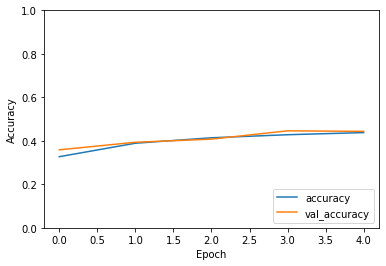

In [13]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

On constate qu'on a une précision d'environ 45%, ce qui est mieux que le hasard, mais n'est pas exceptionnel non plus.

Vous pouvez vous amuser à recréer un modèle en rajoutant plus de couches avec des paramètres différents, et voir si vous arrivez à atteindre une meilleure précision ! ;)

**Attention**, plus vous mettez de couche, plus votre modèle sera long à entrainer. Il y aura également beaucoup plus de chance d'avoir du sur-apprentissage.

## Avec des CNNs

Jusqu'ici, nous avons utilisé des couches denses pour notre réseau de neurones, mais cela n'est pas le plus adapté pour traiter des images. En effet, cela n'est pas insensible aux translations, etc. C'est pourquoi nous allons utiliser des CNN (Convolutional Neural Network) dans la suite.

### Un peu de théorie

Les CNNs sont spécifiquement faits pour travailler sur des images !

Chaque image est un tableau de taille *largeur x longueur x canaux* (les canaux peuvent être au nombre de 3 pour une image couleur ou 1 pour une image en nuances de gris. On applique alors un filtre, qui est un tableau de largeur et longueur inférieures, mais de nombres de canaux identiques ! Le filtre sert de coefficients pour sommer la valeur des pixels en dessous, et on décale le filtre jusqu'à avoir couvert toute l'image.

Ci-dessus un exemple.

![](https://miro.medium.com/max/413/1*4yv0yIH0nVhSOv3AkLUIiw.png)
![](https://miro.medium.com/max/268/1*MrGSULUtkXc0Ou07QouV8A.gif)

Voilà, quelques filtres communs, on voit que cela peut servir pour la détection de bord par exemple !

![](https://miro.medium.com/max/349/1*uJpkfkm2Lr72mJtRaqoKZg.png)

Il y a d'autres paramètres qu'on ne détaillera pas ici. Au sein d'une couche CNN, il peut y avoir plusieurs filtres. La sortie est alors une image de même largeur et longueur, mais le nombre de canaux est alors égale au nombre de filtres. L'entrainement d'un CNN revient à déterminer les coefficients de ces filtres.

Cependant, vous remarquerez qu'ici, on ne diminue pas la taille d'une image, mais qu'on joue seulement sur la profondeur de celle-ci. Afin, de réduire la dimension de celle-ci, nous allons utiliser du `Pooling`, notamment, du `MaxPooling` qui revient à considérer la valeur maximale en déplaçant un filtre à chaque fois (Voir l'illustration ci-dessous).

![](https://miro.medium.com/max/602/1*SmiydxM5lbTjoKWYPiuzWQ.png)

La `MaxPooling` réduit donc la surface de l'image, tout en gardant la même profondeur. Par exemple, avoir un carré de *2x2* pour le `MaxPooling` divisera la largeur et la longeur de l'image sortante par 2.

Le fait de chainer des CNNs permet au modèle d'apprendre des motifs complexes. Les premiers CNNs détecteront les bords, etc. Tandis que les suivants pourront agréger tout ça pour reconnaitre des formes plus évoluées. Après les CNNs, nous pouvons mettre un réseau dense, afin de faire la classification à partir des *features* extraites des CNNs.

### En pratique

Avec **Keras**, on peut définir un CNN avec les couches suivantes :

- `keras.layers.Conv2D(n_filtres, longueur_filtre, activation='relu')`

  - `n_filtres` : Le nombre de filtres du CNN
  
  - `longueur_filtre` : Définit la largeur du filtre qui sera un carré.
  
  - `activation` : Fonction d'activation, on prendra `'relu'`
  
  
- `keras.layers.MaxPooling(largeur)`

  - `largeur` : Largeur du carré du Pooling
  
Dans la partie CNN du modèle, on alternera les couches `Conv2D` et `MaxPooling`.
  
Dans la définition de notre modèle, puisque les CNNs prennent en entrée une image, nous n'avons plus besoin de la couche `Flatten` au début.

#### Définition du modèle

**Instruction :**
1. Créer un modèle que vous assignerez à `model_cnn1`.
2. Rajoutez une couche `Conv2D` avec 64 filtres, une largeur de 3, la fonction d'activation relu et input_shape=(32, 32, 3) (Il faut préciser pour la première couche le format des données d'entrée).
3. Rajoutez une couche `MaxPooling` de largeur 3.
2. Rajoutez une couche `Conv2D` avec 64 filtres, une largeur de 3 et la fonction d'activation relu.
3. Rajoutez une couche `MaxPooling` de largeur 3.
5. Rajoutez une couche `Conv2D` avec 64 filtres, une largeur de 3 et la fonction d'activation relu.

Cela correspondra à notre partie CNN.

In [14]:
model_cnn1 = models.Sequential()
model_cnn1.add(layers.Conv2D(32, 3, activation='relu', input_shape=(32, 32, 3)))
model_cnn1.add(layers.MaxPooling2D(2))
model_cnn1.add(layers.Conv2D(64, 3, activation='relu'))
model_cnn1.add(layers.MaxPooling2D(2))
model_cnn1.add(layers.Conv2D(64, 3, activation='relu'))

Passons maintenant à la partie dense. À la dernière couche, les données sont sous la forme d'une tableau et non d'une liste. Il faut donc de nouveau utiliser la couche `Flatten` comme toute à l'heure!

**Instruction :**
1. Ajoutez une couche `Flatten`.
2. Rajoutez une couche `Dense` avec 64 noeuds et la fonction d'activation `relu`.
2. Rajoutez une couche `Dense` avec 10 noeuds et la fonction d'activation `softmax`.

In [15]:
model_cnn1.add(layers.Flatten())
model_cnn1.add(layers.Dense(64, activation='relu'))
model_cnn1.add(layers.Dense(10, activation='softmax'))

#### Préparation du modèle à l'entrainement

**Instructions :**
1. Visualisez votre modèle avec `summary()`
2. Compiler votre modèle avec la fonction `compile()` et les mêmes paramètres que la partie prédédente.

In [16]:
model_cnn1.summary()
model_cnn1.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

#### Entrainement

Votre modèle est maintenant prêt à être entrainer !

**Instructions :** Entrainer votre modèle à l'aide de la fonction `fit()`.

In [17]:
history = model_cnn1.fit(train_images, train_labels,
                         epochs=5,
                         validation_data=(test_images, test_labels))

Epoch 1/5
1563/1563 [==============================] - 31s 20ms/step - loss: 1.5468 - accuracy: 0.4346 - val_loss: 1.3141 - val_accuracy: 0.5222
Epoch 2/5
1563/1563 [==============================] - 31s 20ms/step - loss: 1.1772 - accuracy: 0.5831 - val_loss: 1.1892 - val_accuracy: 0.5825
Epoch 3/5
1563/1563 [==============================] - 30s 19ms/step - loss: 1.0293 - accuracy: 0.6398 - val_loss: 0.9841 - val_accuracy: 0.6569
Epoch 4/5
1563/1563 [==============================] - 31s 20ms/step - loss: 0.9299 - accuracy: 0.6746 - val_loss: 0.9558 - val_accuracy: 0.6667
Epoch 5/5
1563/1563 [==============================] - 31s 20ms/step - loss: 0.8604 - accuracy: 0.6992 - val_loss: 0.9008 - val_accuracy: 0.6856


De la même façon que tout à l'heure, regardons les performances de notre modèle.

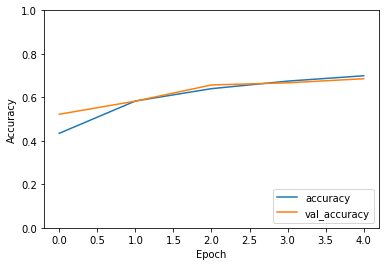

In [18]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

On observe ici une précision plus élevée, mais celle-ci plafonne à 70% ... Ce qui est quand même mieux que le modèle uniquement avec des couches denses ! De plus, nous avons beaucoup moins de paramètres à entrainer et l'entrainement est plus rapide.

Vous pouvez vous amusez à changez les paramètres et les couches pour voir si vous arrivez à avoir une précision plus élevée encore !

# Auto-encodeurs et applications diverses

Dans la partie précédente, on devinait directement à partir de l'image qu'elle était sa classe. Maintenant, nous allons supposer que nous ne connaissons pas les classes des images, et nous allons essayer de trouver des similarités entre toutes les images. Pour se faire, nous allons utiliser des auto-encodeurs.


## Un auto-enco-quoi ?

Les **auto-encodeurs** sont une famille de réseaux de neurones particuliers qui ont pour premier objectif de réduire la dimension de l'espace des données qui nous intéressent. Il se décomposent en deux parties :

*   Un encodeur qui doit apprendre la représentation des données d'entrée qui permet de passer de la dimension initiale à la dimension réduite.
*   Un décodeur qui doit reproduire l'entrée le plus fidèlement possible à partir de la représentation que donne l'encodeur.

On retrouve donc un structure caractéristique en "goulot d'étranglement" où les couches aux extrémités sont de la même dimension que la taille des données à caractériser et où la couche centrale est de la dimension de réduction souhaitée qui contiendra la représentation des entrées.

![](https://www.researchgate.net/publication/318204554/figure/fig1/AS:512595149770752@1499223615487/Autoencoder-architecture.png)

Pour entrainer ce réseau, on va seulement utilisée les données d'entrées : pas besoin donc de labéliser les données, on laisse la descente de gradient faire tout le travail : il s'agit d'un apprentissage non-supervisé.

## Un premier exemple

On a vu précédemment que les couches denses n'étaient pas très adaptées pour manipuler les images. Mais pour bien comprendre le concept de l'auto-encodeur, on va commencer avec ça.

Si vous avez bien suivi, un auto-encodeur est composé de deux modèles : un encodeur, et un décodeur. Ce dernier est souvent un symétrique de l'encodeur.

On va donc créer une classe `AutoencoderDense` qui contiendra ces deux modèles.

*Note :* Pas d'inquiétude si vous n'êtes pas familié avec les classes, vous en manipulez déjà depuis toute à l'heure sans le savoir, et ici la structure sera déjà présente, vous n'aurez qu'à compléter les parties manquantes.

`latent_dim` est la dimension de la couche latente de l'auto-encodeur, c'est-à-dire la couche au milieu de celui-ci.

**Instructions (Encodeur) :**
1. Rajoutez une couche `Flatten` en précisant `input_shape` à `encoder`.

   Les données d'entrée sont les images.
  
2. Rajoutez une couche `Dense` avec 1024 noeuds et la fonction d'activation `relu` à `encoder`.
3. Rajoutez une couche `Dense` avec `latent_dim` noeuds et la fonction d'activation `relu` à `encoder`.


**Instructions (Décodeur) :**
1. Rajoutez une couche `Dense` avec 1024 noeuds, la fonction d'activation `relu` et `input_shape` à `decoder`.

   Les données d'entrées sont les valeurs de la couche latente, qui est de dimension `latent_dim`.
   
   **Attention :** `input_shape` prend en argument un tuple, donc méfiez-vous ... Affichez (45) et (45,) si vous ne voyez pas le problème.


2. Rajoutez une couche `Dense` avec 32 * 32 * 3 noeuds (ie le nombre de valeurs d'entrée) et la fonction d'activation `sigmoid` à `decoder`.

   À votre avis, pourquoi utilise-t-on la fonction d'activation sigmoid plutôt que relu pour cette dernière couche ? Je vous invite à regarder sur Google à quoi ressemble ces deux fonctions, et à réfléchir à ce qu'on prévoit avec cette dernière couche.
   
   
3. Rajoutez une couche `Reshape((32, 32, 3))` à `decoder` afin de mettre tout ça sous la forme d'une image couleur.

In [19]:
class AutoencoderDense(Model):
    def __init__(self, latent_dim):
        super().__init__()
        
        self.latent_dim = latent_dim
        
        # Définition de l'encodeur
        encoder = keras.Sequential(name='encoder')
        encoder.add(layers.Flatten(input_shape=(32, 32, 3)))
        encoder.add(layers.Dense(1024, activation='relu'))
        encoder.add(layers.Dense(latent_dim, activation='relu')) # Couche latente
        
        # Définition du décodeur
        decoder = keras.Sequential(name='decoder')
        decoder.add(layers.Dense(1024, activation='relu', input_shape=(latent_dim,)))
        decoder.add(layers.Dense(32 * 32 * 3, activation='sigmoid'))
        decoder.add(layers.Reshape((32, 32, 3)))
        
        # Sauvegarde de l'encodeur et du décodeur
        self.encoder = encoder
        self.decoder = decoder

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def summary(self):
        self.encoder.summary()
        self.decoder.summary()


Vous venez de définir la classe de l'auto-encodeur, il ne reste plus qu'à en créer un !

**Instructions :**
1. Créez un autoencodeur avec : `autoencoder_dense = AutoencoderDense(latent_dim)`.


2. Affichez sa description avec : `autoencoder_dense.summary()`.

In [20]:
latent_dim = 512
autoencoder_dense = AutoencoderDense(latent_dim)
autoencoder_dense.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              3146752   
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
Total params: 3,671,552
Trainable params: 3,671,552
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_7 (Dense)              (None, 3072)              3148800   
________________________________

Pour ceux qui ne sont pas familier avec les classes, vous remarquez que vous venez de créer votre première classe ! ;)

Il ne reste plus qu'à le compiler, et à l'entrainer !

**Instructions :**
1. Compilez `autoencoder_dense` avec la fonction `compile` et les paramètres suivants : `'adam'` comme optimiseur et `losses.MeanSquaredError()` comme loss.


2. Entrainez `autoencoder_dense` avec la fonction `fit`.

   **Attention**, les données de sortie ne sont plus les mêmes ! En effet, on cherche à reconstruire l'image en entrée après avoir réduit sa dimension.

In [21]:
autoencoder_dense.compile(optimizer='adam', loss=losses.MeanSquaredError())

autoencoder_dense.fit(train_images, train_images,
                    epochs=1,
                    validation_data=(test_images, test_images))

1563/1563 [==============================] - 77s 50ms/step - loss: 0.0202 - val_loss: 0.0140


Vous disposez maintenant d'un modèle capable, en théorie, de copier les images qu'on lui passe en entrée ... Regardons un peu ça.

Le code qui suit prends `n` indices au hasard, et affiche l'image originale et l'image en sortie de l'auto-encodeur correspondant à chaque indice.

Vous pouvez voir qu'on accède à l'encodeur et au décodeur de notre modèle à l'aide de `autoencoder_dense.encoder` et `autoencoder_dense.decoder`.

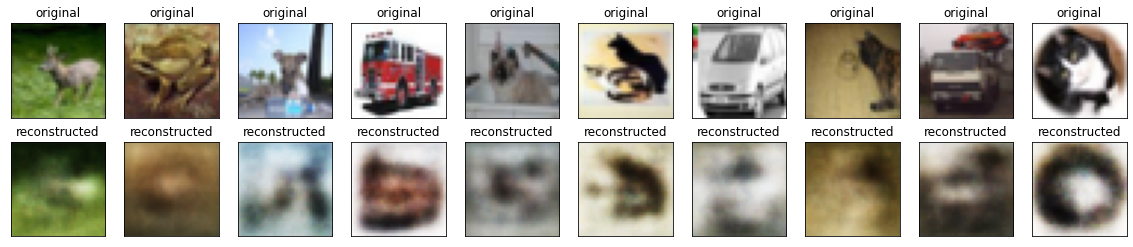

In [22]:
n = 10
indices = np.random.choice(len(test_images), n)

encoded_imgs = autoencoder_dense.encoder(test_images[indices]).numpy()
decoded_imgs = autoencoder_dense.decoder(encoded_imgs).numpy()

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images[indices][i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Bilan ? C'est un peu flou tout ça. On pouvait s'y attendre. Notre réseau est composé uniquement de couches denses et le dataset est assez compliqué, notre modèle est donc très mal adapté.

C'est pourquoi nous allons utilisé des CNNs ! Après la partie précédente, vous avez au moins une vague idée de ce que c'est. L'essentiel à retenir est que les CNNs sont beaucoup plus efficaces pour traiter des images.

## Un deuxième exemple

De la même façon que précédemment, nous allons créer une classe `AutoencoderCNN`.

**Instructions (Encodeur) :**
1. Rajoutez une couche `Conv2D` de 64 filtres, de taille 3, de fonction d'activation `'relu'` et de `padding='same'` en précisant `input_shape` à `encoder`. 
2. Rajoutez une couche `MaxPooling2D` de taille 2 à `encoder`.
3. Rajoutez une couche `Conv2D` de 32 filtres, de taille 3, de fonction d'activation `'relu'` et de `padding='same'` à `encoder`. 
4. Rajoutez une couche `MaxPooling2D` de taille 2 à `encoder`.
3. Rajoutez une couche `Flatten` à `encoder`.
3. Rajoutez une couche `Dense` avec `latent_dim` noeuds et la fonction d'activation `relu` à `encoder`.


**Instructions (Décodeur) :**
1. Rajoutez une couche `Reshape((8, 8, 16))` en précisant `input_shape` à `decoder`. 
2. Rajoutez une couche `UpSampling2D` de taille 2 à `decoder`. Cette couche permet de doubler la longueur et largueur de l'image. Ce qui à un effet un peu "inverse" au MaxPooling.
3. Rajoutez une couche `Conv2D` de 16 filtres, de taille 3, de fonction d'activation `'relu'` et de `padding='same'` à `decoder`. 
4. Rajoutez une couche `UpSampling2D` de taille 2 à `decoder`.
5. Rajoutez une couche `Conv2D` de 32 filtres, de taille 3, de fonction d'activation `'relu'` et de `padding='same'` à `decoder`. 
6. Rajoutez une couche `Conv2D` de 3 filtres, de taille 3, de fonction d'activation `'sigmoid'` et de `padding='same'` à `decoder`. 

In [23]:
latent_dim = 8 * 8 * 16

class AutoencoderCNN(Model):
    def __init__(self, latent_dim):
        super().__init__()
        
        self.latent_dim = latent_dim
        
        # Définition de l'encodeur
        encoder = keras.Sequential(name='encoder')
        encoder.add(layers.Conv2D(32, 3, activation='relu', padding='same', input_shape=(32, 32, 3)))
        encoder.add(layers.MaxPooling2D(2))
        encoder.add(layers.Conv2D(16, 3, activation='relu', padding='same'))
        encoder.add(layers.MaxPooling2D(2))
        
        encoder.add(layers.Flatten()) # Préparation couche latente
        encoder.add(layers.Dense(latent_dim, activation='relu')) # Couche latente
        
        # Définition du décodeur
        decoder = keras.Sequential(name='decoder')
        decoder.add(layers.Reshape((8, 8, 16), input_shape=(latent_dim,)))
        decoder.add(layers.UpSampling2D(2))
        decoder.add(layers.Conv2D(16, 3, activation='relu', padding='same'))
        decoder.add(layers.UpSampling2D(2))
        decoder.add(layers.Conv2D(32, 3, activation='relu', padding='same'))
        decoder.add(layers.Conv2D(3, 3, activation='sigmoid', padding='same'))
        
        # Sauvegarde de l'encodeur et du décodeur
        self.encoder = encoder
        self.decoder = decoder

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def summary(self):
        self.encoder.summary()
        self.decoder.summary()


Il ne reste plus qu'à le créer, le compiler et l'entrainer maintenant.

**Instructions :**
1. Créez un autoencodeur avec : `autoencoder_cnn = AutoencoderCNN(latent_dim)`.
2. Compilez `autoencoder_cnn` avec a fonction `compile` et les paramètres suivants : `'adam'` comme optimiseur et `losses.MeanSquaredError()` comme loss.


3. Entrainez `autoencoder_cnn` avec la fonction `fit`.

In [25]:
autoencoder_cnn = AutoencoderCNN(latent_dim)
autoencoder_cnn.compile(optimizer='adam', loss=losses.MeanSquaredError())

autoencoder_cnn.fit(train_images, train_images,
                    epochs=1,
                    validation_data=(test_images, test_images))

1563/1563 [==============================] - 120s 77ms/step - loss: 0.0118 - val_loss: 0.0076


Regardons maintenant ce que le modèle réussit à faire ! C'est mieux, mais ce n'est pas parfait encore ...

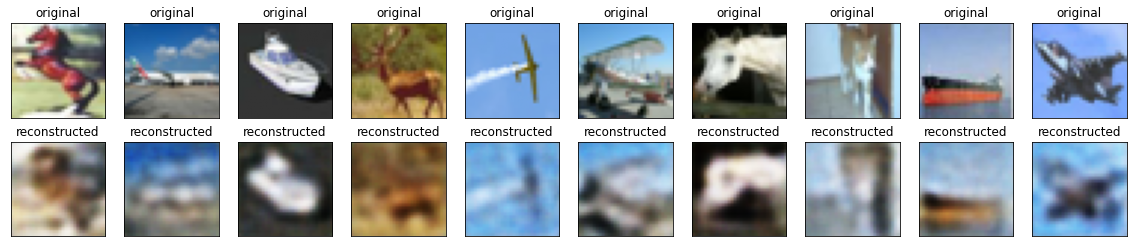

In [26]:
n = 10
indices = np.random.choice(len(test_images), n)

encoded_imgs = autoencoder_cnn.encoder(test_images[indices]).numpy()
decoded_imgs = autoencoder_cnn.decoder(encoded_imgs).numpy()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images[indices][i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Il existe de nombreuses techniques pour améliorer les auto-encodeurs, mais nous n'allons pas nous intéresser à ça dans la suite du TP. Nous allons voir d'autres applications des auto-encodeurs, et d'autres techniques d'apprentissage non-supervisé.

## Applications diverses d'un auto-encodeur

Les auto-encodeurs peuvent servir pour la compression (avec perte), mais pas seulement !

On peut aussi s'en servir pour débuiter des images ou faire de la génération de contenu.

On va commencez par définir un auto-encodeur un peu plus efficace.

In [29]:
class AutoencoderCNN2(Model):
    def __init__(self):
        super().__init__()
        
        # Définition de l'encodeur
        encoder = keras.Sequential([
            layers.Conv2D(32, 3, 1, activation='relu', padding='same'), # 32 x 32 x 32
            layers.BatchNormalization(),
            layers.Conv2D(32, 3, 2, activation='relu', padding='same'), # 16 x 16 x 32
            layers.Conv2D(32, 3, 1, activation='relu', padding='same'), # 16 x 16 x 32
            layers.BatchNormalization(),
            #layers.Conv2D(32, 3, 2, activation='relu', padding='same'), # 8 x 8 x 32
            #layers.Conv2D(32, 3, 1, activation='relu', padding='same'), # 8 x 8 x 32
        ], name='encoder')
        
        # Définition du décodeur
        decoder = keras.Sequential([
            #layers.UpSampling2D(), # 16 x 16 x 32
            #layers.Conv2D(32, 3, 1, activation='relu', padding='same'), # 16 x 16 x 32
            layers.UpSampling2D(), # 32 x 32 x 32
            layers.Conv2D(32, 3, 1, activation='relu', padding='same'), # 32 x 32 x 32
            layers.BatchNormalization(),
            layers.Conv2D(3, 1, 1, activation='sigmoid', padding='same') # 32 x 32 x 3
        ], name='decoder')
        
        # Sauvegarde de l'encodeur et du décodeur
        self.encoder = encoder
        self.decoder = decoder

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def summary(self):
        self.encoder.summary()
        self.decoder.summary()

### Le débruitage

On va entrainer notre modèle a prédire les images non-bruités à partir d'images bruitées.

In [30]:
ae = AutoencoderCNN2()
ae.compile(optimizer='adam', loss=losses.MeanSquaredError())

À chaque époque, nous générons de nouvelles images bruitées.

In [31]:
n_epochs = 1
NOISE = 0.1     #  Set to 0 for a regular (non-denoising...) autoencoder
for i in range(n_epochs):
    noise = np.random.normal(0, NOISE, train_images.shape)
    
    # Keep value between 0 and 1
    imgs = train_images + noise
    imgs = np.where(imgs > 1, 1, imgs)
    imgs = np.where(imgs < 0, 0, imgs)
    ae.fit(imgs, train_images, epochs=1)

1563/1563 [==============================] - 116s 74ms/step - loss: 0.0038


Voyons voir ce que ça donne.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



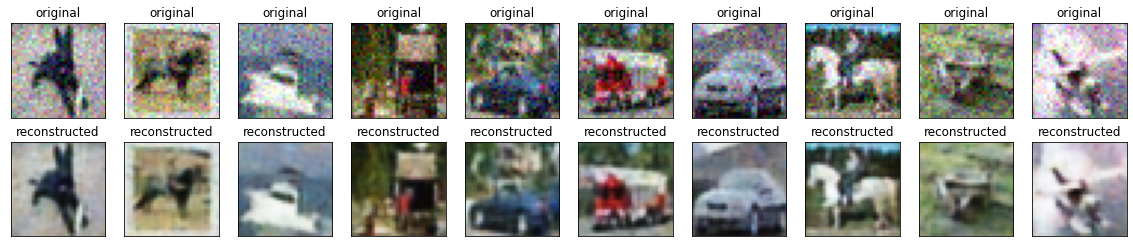

In [32]:
n = 10
indices = np.random.choice(len(test_images), n)

NOISE = 0.1
imgs = (test_images + np.random.normal(0, NOISE, test_images.shape))[indices]

# Keep value between 0 and 1
imgs = np.where(imgs > 1, 1, imgs)
imgs = np.where(imgs < 0, 0, imgs)

denoised_imgs = ae(imgs)

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(imgs[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(denoised_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

On voit que cela fonctionne plutôt bien !

### La génération d'image

L'idée est la suivante : La couche latente est un vecteur de taille N que le décodeur sait transformer en image, donc si on peut générer des vecteurs aléatoires, et obtenir des nouvelles images, non ?

Dans un premier temps, on va déjà récupérer toutes les images avec des bateaux pour savoir exactement quelle classe le modèle essayera de générer.

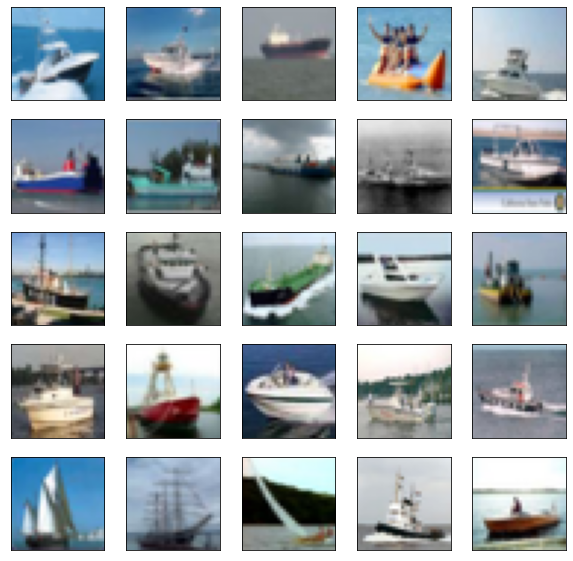

In [33]:
ind_train = train_labels == 8
ind_train = ind_train.reshape((-1,))
boats_imgs_train = train_images[ind_train, :, :]

ind_test = test_labels == 8
ind_test = ind_test.reshape((-1,))
boats_imgs_test = test_images[ind_test, :, :]

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(boats_imgs_train[i], cmap=plt.cm.binary)
plt.show()

Dans un premier temps, nous allons entrainer un auto-encodeur sur ces magnifiques images de bateaux. Le nombre d'images étant divisé par 10, l'entrainement va allez beaucoup plus vite !

In [34]:
ae_gen = AutoencoderCNN2()
ae_gen.compile(optimizer='adam', loss=losses.MeanSquaredError())

ae_gen.fit(boats_imgs_train, boats_imgs_train,
                    epochs=5,
                    validation_data=(boats_imgs_test, boats_imgs_test))

Epoch 1/5
157/157 [==============================] - 12s 77ms/step - loss: 0.0086 - val_loss: 0.0301
Epoch 2/5
157/157 [==============================] - 13s 82ms/step - loss: 0.0026 - val_loss: 0.0136
Epoch 3/5
157/157 [==============================] - 13s 83ms/step - loss: 0.0019 - val_loss: 0.0031
Epoch 4/5
157/157 [==============================] - 12s 76ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 5/5
157/157 [==============================] - 12s 75ms/step - loss: 0.0015 - val_loss: 0.0011


Essayons maintenant de générer des vecteurs aléatoires de la taille de la couche latente, et voyons si ça fonctionne ...

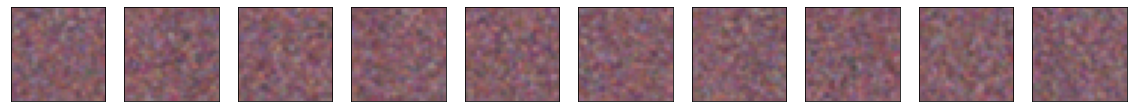

In [35]:
random_vectors = np.random.normal(0, .3, size=(10, 16*16*32))
random_vectors = random_vectors.reshape((-1, 16, 16, 32))
generated_imgs = ae_gen.decoder(random_vectors)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(generated_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Bof ... C'est pas très concluant comme test, et c'est normal. En réalité, les 16 x 16 x 32 = 8192 coordonées du vecteur de l'espace latent sont corrélées, on ne peut donc pas mettre des valeurs complétement aléatoires. On va utiliser un algorithme linéaire afin de décorreler les variables de notre espace latent afin de s'assurer de générer des bateaux qui sont "dans la moyenne"; il s'agit de l'algorithme PCA (analyse en composante principale, pour les matheux c'est pas très compliqué et on peut l'implémenter soit même, voir sur [wikipédia](https://fr.wikipedia.org/wiki/Analyse_en_composantes_principales)).

L'idée général est de trouver les axes qui expliquent le plus notre nuage de points. Bref, si c'est pas clair, vous le verrez durant le cours de Statistiques & Apprentissages.

Ici, on va utiliser le PCA déjà écrit de la librairie **scikit-learn**.

In [36]:
from sklearn.decomposition import PCA

In [56]:
# Génération de notre nuage de points
samples_pca = ae_gen.encoder(boats_imgs_test)
reshaped_samples_pca = tf.reshape(samples_pca, (-1, 16*16*32)) # On les reshape, car ils sont de la forme 16x16x32

N = 85
pca = PCA(n_components=N, svd_solver='full')
pca.fit(reshaped_samples_pca)

PCA(n_components=85, svd_solver='full')

**Explication du code ci-dessus :**
- Dans un premier temps, on crée notre nuage de points, c'est-à-dire l'ensemble des vecteurs latents issus des images de test. 

- On crée un objet `PCA`. `n_components` précise le nombre d'axes qui nous intéresse, l'algorithme PCA effectura alors une réduction de dimension sur ces axes.

- Finalement, on ajuste les paramètres à partir de notre nuage de points avec la fonction `fit`.

Passons enfin à la génération de 49 magnifiques bateaux !

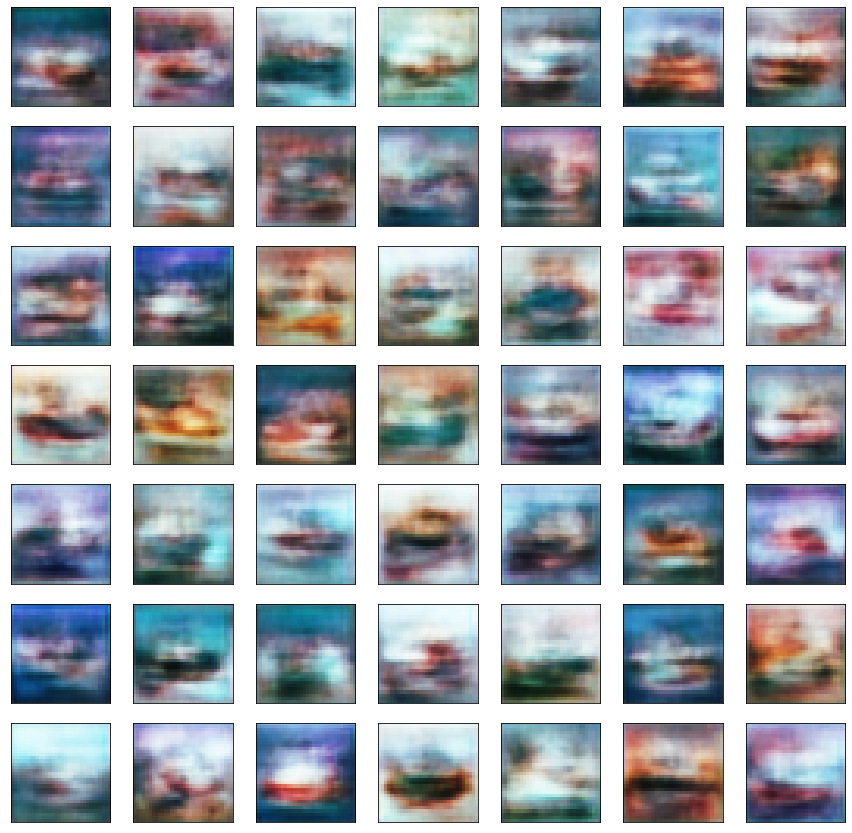

In [57]:
n = 49

# On regarde comment varie les vecteurs latents réduits pour ne pas générer des valeurs trop différentes.
a = pca.transform(reshaped_samples_pca)
random_vectors = np.random.normal(loc=np.mean(a, axis=0), scale=np.std(a, axis=0), size=(n, N))

# On transforme les vecteurs en vecteurs valables pour l'espace latent
random_vectors = pca.inverse_transform(random_vectors) # Transforme les vecteurs réduits dans l'espace initial
random_vectors = random_vectors.reshape((-1, 16, 16, 32))

# On transforme les vecteurs de l'espace latent en image
decoded_random_images = ae_gen.decoder(random_vectors)

plt.figure(figsize=(15,15))
for i in range(49):
    plt.subplot(7,7,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(decoded_random_images[i], cmap=plt.cm.binary)
plt.show()

J'ai peut-être menti ... Ils ne sont pas si magnifiques, mais c'est déjà un début. Le type d'auto-encodeur que nous avons défini n'est pas vraiment fait pour la génération, les auto-encodeurs variationnels sont plus adaptés.

Je vous invite à jouer avec la variable `N` qui définit le paramètre `n_components` dans le code ci-dessus et de voir l'impact qu'il a sur les images générées.

# C'est pas fini, je me concentre sur le code et on complétera le blabla.
# On peut difficielement expliquer tous les algos dans un TP.
# Y'A DES FAUTES PARTOUT JE SAIS PAS ECRIRE (j'ai pas encore relu)
# Ca va être tendu

## Analyse des caractéristiques profondes de l'auto-encodeur et clustering

Les vecteurs que l'on obtient après compression par l'auto-encodeur sont appelés **vecteur latents**, ou **caractéristiques profondes**, ou **deep features**.
Ces termes ne sont pas réservés aux auto-encodeurs, il s'agit de n'importe quels vecteurs de dimension réduite provenant d'un réseau profond, par exemple en le tronquant quelques couches avant la fin.

Ces vecteurs sont très utiles car ils sont de petites dimensions mais sont porteurs d'information sémantique. Autrement dit, ils "encodent" les données d'entrée du réseau, et sont un condensé des informations importantes.

> Prenons un exemple.
> Vous entrainez un réseau à reconnaitre des voitures (donc supervisé). Une fois que votre réseau est efficace sur des voitures, vous le coupez quelques couches avant la fin. Vous obtenez un réseau qui prend en entrée des images et donne en sortie un vecteur de petite dimension, disons 64.
Ensuite, vous donnez à ce réseau des images de motos et de camions, et c'est là que la magie se produit : votre réseau aura appris à extraire les information utiles pour reconnaitre une voiture (roues, forme, etc), et fournira donc des vecteurs qui contiennent ces informations utiles. Une simple comparaison de ces vecteurs pourra indiquer si il s'agit d'une moto ou d'un camion. Il sera évidemment toujours peu efficace pour reconnaitre des objets éloignés des voitures, comme des visages par exemple. 

In [ ]:
#récupération des données de l'auto-encodeur
train_data = autoencoder_cnn.encoder(train_images)
test_data = autoencoder_cnn.encoder(test_images)

train_labels = train_labels.reshape((50000,))
test_labels = test_labels.reshape((10000,))

n = 1000 #nombre de données à afficher
train_data_viz = train_data[:n]
train_labels_viz = train_labels[:n]
test_data_viz = test_data[:n]
test_labels_viz = test_labels[:n]

print(f"Les vecteurs latents sont de dimension {train_data.shape[1]}.")

### Analyse des caractéristiques

Il est souvent nécessaire de réduire la dimension des données que l'on manipule. Un encodeur (par exemple la première partie d'un auto-encodeur) est déjà un moyen de réduire les dimensions en codant des images dans un espace vectoriel beaucoup plus petit.
Un auto-encodeur a le rôle très particulier d'encoder des images (ou autres données structurées), d'autres algorithmes s'appliquent à des données vectorielles classiques.

La réduction de dimension permet à la fois à mieux visualiser les données (par exemple on peut réduire les vecteurs à 2 ou 3 dimensions pour afficher les données sur un graphique), et à la fois de pré-traiter les données. En effet, certains algorithmes, en particulier ceux basés sur la distances, supportent mal des très hautes dimensions.
> Voir "malédiction de la dimension" (https://en.wikipedia.org/wiki/Curse_of_dimensionality)

Dans la suite du TP, nous verrons la transformation t-SNE pour la visualisation, et l'ACP pour le pre-process.

#### Visualisation (t-SNE)

Le t-SNE (pour t-distributed stochastic neighbor embedding) est un algo de réduction de dimension spécialement concu visualisation de données. L'algorithme tend à maintenir les proximités entre les points depuis l'espace de grande dimension vers l'espace de petit dimension, selon une distance donnée.

> Si vous voulez creuser son fonctionnement (ca demande quelques connsaissances en théorie de l'information) : 
> 
- version complète : https://jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf
- version simple : https://aiaspirant.com/introduction-to-t-distributed-stochastic-neighbor-embeddingt-sne/

Notez que ca a été inventé par **Geoffrey Hinton**, un monument de l'IA, père de beaucoup d'autres méthodes. Vous allez probablement recroiser son nom souvent.

Comme on va le voir, le t-SNE n'est pas déterministe, et c'est une chose à ne pas oublier quand vous l'utiliserez.

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
t0 = time()
tsne_results = tsne.fit_transform(train_data_viz)
print(f"Done in {time() - t0}s")
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=train_labels_viz, cmap=matplotlib.colors.ListedColormap(colors))

#afficher aussi avec les couleurs

Le t-SNE n'est pas déterministe. Vous pouvez le vérifier en lancant plusieurs fois la réduction, vous n'aurez jamais le même résultat.

#### Réduction de dimension (ACP/PCA)

L'Analyse en Composante Principale est une autre méthode de réduction de dimension. L'ACP repose sur un principe intuitif : on recherche les directions dans lesquelles les données s'étalent le plus.

BLABLABLA (https://fr.wikipedia.org/wiki/Analyse_en_composantes_principales l'article wikipedia est très bien fait)

C'est la technique qui est de très loin la plus utilisée pour la réduction de dimension. Elle permet notamment de savoir combien d'information on perd lorsque l'on réduit la dimension. Elle a beaucoup d'autres avantages qui seront détaillés dans la suite.

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10, svd_solver='full', whiten=True)

t0 = time()
pca_results = pca.fit_transform(train_data_viz)
print(f"Done in {time() - t0}s")

explained_variance = pca.explained_variance_ratio_
plt.plot(explained_variance)
plt.show()
print('Explained variation per principal component: \n {}'.format(pca.explained_variance_ratio_))

Le graph précédent montre la proportion de variance expliquée sur chacune des composantes principales. Intuitivement, il s'agit de l'information contenue dans chacune des composantes.
La méthode classique pour savoir combien de dimension on doit garder consiste à ne garder que les composantes qui se situent avant le point d'inflexion de la courbe.
En ce qui concerne les données que l'on manipule, on remarque que ---- dimensions sont nécessaire pour expliquer --- % de la variance.
Si l'auto-encodeur avait un espace latent de plus petite dimension, l'information aurait été mieux répartie parmis les composantes.

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10, svd_solver='full', whiten=True)

t0 = time()
pca_results = pca.fit_transform(train_data_viz)
print(f"Done in {time() - t0}s")

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
plt.scatter(tsne_results[:,0], pca_results[:,1], c=train_labels_viz, cmap=matplotlib.colors.ListedColormap(colors))

#### Pourquoi une ACP, pourquoi un t-SNE ?

On l'a vu, le t-SNE a l'air d'être efficace pour réduire les dimensions, alors pourquoi on utilise une ACP pour le traitement réel des données ? 

C'est parce-que la transformation t-SNE souffre de quelques points noirs :

- Le t-SNE, comme on l'a vu, n'est pas déterministe. La sortie change à chaque éxecution, ce qui peut poser problème pour la manipulation des données après la transformation. L'ACP fournit des résultats déterministes.

- Le t-SNE se base sur les relations entre les points voisins mais ne permet pas toujours de visualiser les tendances globales. Vous aurez toujours des données bien étalée dans l'espace alors que les données d'entrée ne le sont pas forcément. C'est aussi ce qui rend le t-SNE parfois très utile pour visualiser les données.

- Les composantes principales en sortie d'ACP portent en elles-même une signification puisqu'elles se décomposent selon des composantes d'entrée. Si les données d'entrée ont un sens, alors les sorties auront un sens.
> Par exemple, si je veux prédire le prix d'une maison, une ACP nous d'anoncer : "La composante principale qui explique le prix d'une maison est composée à 20% de sa localisation, à 30% de sa surface", etc.

- L'ACP permet d'obtenir les matrices de passage d'un espace à l'autre qui peuvent être utilisées pour projeter facilement de nouvelles données dans l'espace réduit.

- L'ACP sert de base a beaucoup d'autres algorithmes, qui sont utiles pour des cas particuliers ou des cas extremes (peu de données, données mal réparties, etc).

In [ ]:
plt.figure(figsize=(16,7))
ax1 = plt.subplot(1, 2, 1)
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=train_labels_viz, cmap=matplotlib.colors.ListedColormap(colors))
ax2 = plt.subplot(1, 2, 2)
plt.scatter(pca_results[:,0], pca_results[:,1], c=train_labels_viz, cmap=matplotlib.colors.ListedColormap(colors))

En comparant les deux algorithmes, on remarque l'étalement provoqué par le t-SNE. C'est utile pour bien visualiser les données mais on perd l'information qui concerne les tendances globales des données.

#### Quelques autres algos

D'autres algorithmes permettent la réduction de dimension, dans des cas particuliers :

- la PLS ou régression des moindres carrés partiels est équivalente à l'ACP mais elle est supervisée. Ca permet de chercher les composantes principales qui permettent le mieux de distinguer les classes (connues) (voir https://fr.wikipedia.org/wiki/R%C3%A9gression_des_moindres_carr%C3%A9s_partiels)

- L'algorithme FCA analyse les relations entre deux variable qualitatives. C'est donc une ACP pour des données d'entrée non numériques, et pour lesquelles on ne peut pas facilement définir de distance.

### Classification supervisée sur l'espace latent

#### K-NN

blablabla :
- principe kNN (ref) continuously changing datasets
- supervisé, car besoin d'avoir des points qui tapissent l'espace
- choix de k
- variantes : [à voir : prendre en compte densité, etc]

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# KNN 
clf = KNeighborsClassifier(5)

clf.fit(train_data_viz, train_labels_viz)
predicted = clf.predict(test_data_viz)

#### Métriques (précision, confusion, etc)

blablabla :
    - liste des métriques possibles (les taux et tout)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

acc = accuracy_score(test_labels_viz, predicted)
print(f"Précision : {100*acc}% \n")

conf_mat = confusion_matrix(test_labels_viz, predicted)
print("Matrice de confusion : ")
print(conf_mat)

### Classification non supervisée (clustering)

#### K-mean

blablabla :
- principe k-mean (ref)
- non supervisé
- choix de k
- variantes



In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=0)
prediction = kmeans.fit_predict(train_data_viz)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

plt.figure(figsize=(16,7))
ax1 = plt.subplot(1, 2, 1)
plt.scatter(pca_results[:,0], pca_results[:,1], c=train_labels_viz, cmap=matplotlib.colors.ListedColormap(colors))
ax2 = plt.subplot(1, 2, 2)
plt.scatter(pca_results[:,0], pca_results[:,1], c=prediction, cmap=matplotlib.colors.ListedColormap(colors))

#### Clustering agglomératif

blablabla :
- principe AC (ref)
- non supervisé
- pas de choix de k car ...
- variantes



In [ ]:
from sklearn.cluster import AgglomerativeClustering

AC = AgglomerativeClustering()
AC.set_params(n_clusters=10)
prediction = AC.fit_predict(train_data_viz)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

plt.figure(figsize=(16,7))
ax1 = plt.subplot(1, 2, 1)
plt.scatter(pca_results[:,0], pca_results[:,1], c=train_labels_viz, cmap=matplotlib.colors.ListedColormap(colors))
ax2 = plt.subplot(1, 2, 2)
plt.scatter(pca_results[:,0], pca_results[:,1], c=prediction, cmap=matplotlib.colors.ListedColormap(colors))

#### Score NMI

blablabla difficulté de faire une métrique
blablabla NMI (REF)

In [ ]:
from sklearn.metrics.cluster import normalized_mutual_info_score as NMI


kmeans = KMeans(n_clusters=10, random_state=0)
prediction = kmeans.fit_predict(train_data_viz)

print("Score NMI :", NMI(prediction, train_labels_viz))

#À vous de jouer ! Tracez le score en MNI en fonction du nombre de cluster (de 5 à 20) :

cluster = []
scores = []

for k in range(5, 51):
  kmeans = KMeans(n_clusters=k, random_state=0)
  prediction = kmeans.fit_predict(train_data_viz)
  cluster.append(k)
  score = NMI(prediction, train_labels_viz)
  scores.append(score)
  print("k = ", k)

plt.plot(cluster, scores)

### Pipeline sci-kit

blblabla les pipeline c'est bien

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


pipeline = Pipeline([
    ('pca', PCA(n_components=10, svd_solver='full', whiten=True)),
    ('kmeans', KMeans(n_clusters=10, random_state=0)),
])


pipeline.fit(train_data_viz)
prediction = pipeline.predict(train_data_viz)

print("Score NMI :", NMI(prediction, train_labels_viz))